In [1]:
import numpy as np
import pandas as pd

In [2]:
def get_numpy_data(data_dframe, features, output):
    data_dframe['constant'] = 1 # add a constant column to an dataframe
    # prepend variable 'constant' to the features list
    features = ['constant'] + features
    # select the columns of data_dataframe given by the ‘features’ list into the dataFrame ‘features_df’
    features_df = pd.DataFrame(data_dframe, columns=features)
    # this will convert the features_df into a numpy matrix with GraphLab Create >= 1.7!!
    features_matrix = features_df.as_matrix()
    # assign the column of data_dframe associated with the target to the variable ‘output_sarray’
    output_series = pd.Series(data_dframe['price'])
    # this will convert the Series into a numpy array:
    output_array = output_series.as_matrix()
    return(features_matrix, output_array)

In [3]:
def normalize_features(features):
    norms = np.linalg.norm(features, axis=0)
    normalized_features = features / norms
    return (normalized_features, norms)

In [4]:
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':float, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}
house_data_train = pd.read_csv('kc_house_data_small_train.csv', dtype=dtype_dict)
house_data_test = pd.read_csv('kc_house_data_small_test.csv', dtype=dtype_dict)
house_data_valid = pd.read_csv('kc_house_data_validation.csv', dtype=dtype_dict)

In [5]:
feature_list = ['bedrooms',  
                'bathrooms',  
                'sqft_living',  
                'sqft_lot',  
                'floors',
                'waterfront',  
                'view',  
                'condition',  
                'grade',  
                'sqft_above',  
                'sqft_basement',
                'yr_built',  
                'yr_renovated',  
                'lat',  
                'long',  
                'sqft_living15',  
                'sqft_lot15']
features_train, output_train = get_numpy_data(house_data_train, feature_list, 'price')
features_test, output_test = get_numpy_data(house_data_test, feature_list, 'price')
features_valid, output_valid = get_numpy_data(house_data_valid, feature_list, 'price')

In [6]:
features_train, norms = normalize_features(features_train) # normalize training set features (columns)
features_test = features_test / norms # normalize test set by training set norms
features_valid = features_valid / norms # normalize validation set by training set norms

In [12]:
print features_test[0]

[ 0.01345102  0.01551285  0.01807473  0.01759212  0.00160518  0.017059    0.
  0.05102365  0.0116321   0.01564352  0.01362084  0.02481682  0.01350306
  0.          0.01345387 -0.01346922  0.01375926  0.0016225 ]


In [13]:
print features_train[9]

[ 0.01345102  0.01163464  0.00602491  0.0083488   0.00050756  0.01279425
  0.          0.          0.01938684  0.01390535  0.0096309   0.
  0.01302544  0.          0.01346821 -0.01346251  0.01195898  0.00156612]


In [14]:
print (np.sqrt(np.sum((features_test[0] - features_train[9])**2)))

0.059723593714


In [16]:
distance = []
for i in range(0,10):
    distance.append(np.sqrt(np.sum((features_test[0] - features_train[i])**2)))

In [128]:
np.array(distance).argmin()

8

In [21]:
diff = features_train[0:len(features_train)] - features_test[0]

In [32]:
print features_train.shape
print diff.shape

(5527L, 18L)
(5527L, 18L)


In [33]:
print np.sum(diff**2, axis=1)[15] # take sum of squares across each row, and print the 16th sum
print np.sum(diff[15]**2) # print the sum of squares for the 16th row -- should be same as above

0.00330705902846
0.00330705902846


In [34]:
distances = np.sqrt(np.sum(diff**2, axis=1))

In [35]:
distances

array([ 0.06027471,  0.08546881,  0.06149946, ...,  0.05716729,
        0.05705739,  0.05846758])

In [36]:
print distances[100]

0.0237082324167


In [77]:
def OneNN(feature_matrix, query_data):
    diff = feature_matrix[0:len(feature_matrix)] - query_data
    return np.sqrt(np.sum(diff**2, axis=1))

In [129]:
output = OneNN(features_train, features_test[2])

In [130]:
output.min()

0.0028604955575117085

In [131]:
output.argmin()

382

In [132]:
output[382]

0.0028604955575117085

In [133]:
output_train[382]

249000.0

In [83]:
A = np.array([1, 7, 9, 2, 0.1, 17, 17, 1.5])
A[np.argsort(A)[:3]]

array([ 0.1,  1. ,  1.5])

In [92]:
def fetchKNN(k, feature_matrix, query_data):
    dist = OneNN(feature_matrix, query_data)
    shortest_distances = dist[np.argsort(dist)[:k]]
    output_index = np.argsort(dist)[:k]
    return(shortest_distances, output_index)

In [93]:
dist_matrix, output_matrix = fetchKNN(4, features_test[2], features_train)

In [94]:
print dist_matrix
print output_matrix

[ 0.0028605   0.00322584  0.00350216  0.00359315]
[ 382 1149 4087 3142]


In [95]:
np.average(output_train[output_matrix])

413987.5

In [96]:
def KNNprediction(k, train_data, output_train, query_data):
    dist_list, index_list = fetchKNN(k, train_data, query_data)
    return np.average(output_train[index_list])

In [97]:
print KNNprediction(4, features_train, output_train, features_test[2])

413987.5


In [112]:
def multiKNNprediction(k, train_data, output_train, query_matrix):
    output_set =[]
    for i in range(0, query_matrix.shape[0]):
        dist_list, index_list = fetchKNN(k, train_data, query_matrix[i,:])
        output_set.append(np.average(output_train[index_list]))
    return np.array(output_set)

In [113]:
output_set = multiKNNprediction(10, features_train, output_train, features_test[0:10])

In [114]:
output_set

array([ 881300. ,  431860. ,  460595. ,  430200. ,  766750. ,  667420. ,
        350032. ,  512800.7,  484000. ,  457235. ])

In [116]:
output_set.argmin()

6

In [117]:
output_set[6] # 7th House

350032.0

In [120]:
RSS_all = []
for i in range(1,16):
    predicted_val = multiKNNprediction(i, features_train, output_train, features_valid)
    RSS = np.sum((predicted_val - output_valid)**2)
    RSS_all.append(RSS)

In [121]:
RSS_all

[105453830251561.0,
 83445073504025.5,
 72692096019202.562,
 71946721652091.687,
 69846517419718.602,
 68899544353180.836,
 68341973450051.094,
 67361678735491.5,
 68372727958976.094,
 69335048668556.742,
 69523855215598.828,
 69049969587246.172,
 70011254508263.687,
 70908698869034.344,
 71106928385945.156]

In [122]:
np.array(RSS_all).argmin()  #K = 8

7

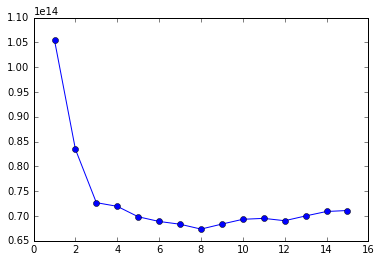

In [124]:
import matplotlib.pyplot as plt
%matplotlib inline

kvals = range(1, 16)
plt.plot(kvals, RSS_all,'bo-')

In [126]:
predicted_val_test = multiKNNprediction(8, features_train, output_train, features_test)
RSS_test = np.sum((predicted_val_test - output_test)**2)

In [127]:
print predicted_val_test
print RSS_test

[ 864750.     462700.     394493.75  ...,  307662.375  681036.     291531.25 ]
1.33118823552e+14
